In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/deep_learning/Final_Project/data.csv')

In [183]:
# 범주형 열을 인코딩
encoder = LabelEncoder()
df['structure_encoded'] = encoder.fit_transform(df['structure'])
df['category_encoded'] = encoder.fit_transform(df['category'])

# 특징과 타겟 정의
X = df.drop(['name', 'log_breakdown_field', 'structure', 'category'], axis=1)
y = df['log_breakdown_field'].values

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [184]:
# 텐서로 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# TensorDataset과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [185]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 64)
        self.layer3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

input_dim = X_train_tensor.shape[1]
hidden_dim = 256
output_dim = 1

# 모델 생성
model = MLP(input_dim, hidden_dim, output_dim)

In [186]:
model

MLP(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [187]:
# 손실 함수 및 optimizer 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [188]:
# 모델 학습
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_train_pred = model(X_batch)
        loss = criterion(y_train_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_test_pred = model(X_batch)
            loss = criterion(y_test_pred, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}")

Epoch 25/1000, Train Loss: 0.810, Test Loss: 1.459
Epoch 50/1000, Train Loss: 0.295, Test Loss: 1.374
Epoch 75/1000, Train Loss: 0.165, Test Loss: 1.476
Epoch 100/1000, Train Loss: 0.119, Test Loss: 1.519
Epoch 125/1000, Train Loss: 0.116, Test Loss: 1.516
Epoch 150/1000, Train Loss: 0.095, Test Loss: 1.485
Epoch 175/1000, Train Loss: 0.073, Test Loss: 1.438
Epoch 200/1000, Train Loss: 0.071, Test Loss: 1.380
Epoch 225/1000, Train Loss: 0.056, Test Loss: 1.350
Epoch 250/1000, Train Loss: 0.051, Test Loss: 1.276
Epoch 275/1000, Train Loss: 0.051, Test Loss: 1.229
Epoch 300/1000, Train Loss: 0.043, Test Loss: 1.159
Epoch 325/1000, Train Loss: 0.035, Test Loss: 1.134
Epoch 350/1000, Train Loss: 0.031, Test Loss: 1.036
Epoch 375/1000, Train Loss: 0.027, Test Loss: 0.964
Epoch 400/1000, Train Loss: 0.020, Test Loss: 0.921
Epoch 425/1000, Train Loss: 0.019, Test Loss: 0.878
Epoch 450/1000, Train Loss: 0.017, Test Loss: 0.842
Epoch 475/1000, Train Loss: 0.012, Test Loss: 0.784
Epoch 500/1000,

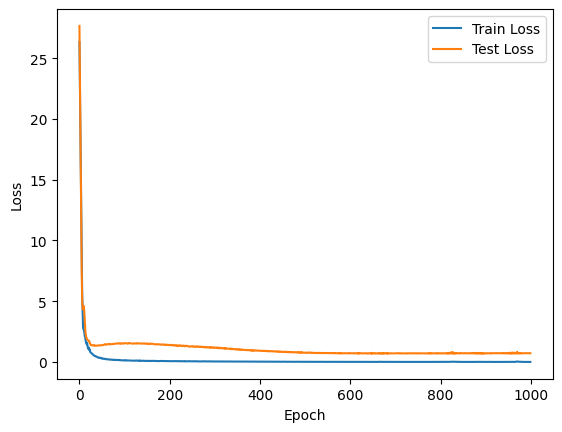

R2 Score: 0.384


In [189]:
# 학습 손실 및 테스트 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

r2 = r2_score(y_test, y_test_pred)
print(f'R2 Score: {r2:.3f}')